In [1]:
import pandas as pd
import numpy as np
import math
import json
from collections import deque
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Business understanding (CRISP-DM Step 1)
- In this project our goal will be to try and predict if we should show a given offer to a given customer
- From a business perspective we want to show offers to those people who satisfy the following conditions
    - who are likely to complete the offer if they viewed the offer
    - who are not likely to complete the offer if they did not view the offer
- The second condition is important because if a customer would complete the offer even without viewing it would mean we need to not have given them the offer in the first place, and starbucks could have saved revenue here.
- If we can identify a subset of customers that satisfies both these conditions then by showing these individuals specific offers we can capture revenue that we would have otherwise missed out on.

### Problem Statement:
Our goal will be identify customers which show a strong positive relationship between viewing an offer and completing it. We will call such customer **responsive** customers.
We will formulate this as a classification problem where a user will be given a positive label (called responsive) when either
1. the user has completed the offer and viewed the offer OR
2. the user has not completed the offer and not viewed the offer

With such a labeling in place our attempt will be to come up with a classifier that predicts whether a customer is responsive based on the features from the customer and the offer being shown to them.

### Strategy
- We will begin with 4 different types of classifiers and conduct a preliminary analysis on their ability to perform the required classification
- After evaluating the preliminary modeling stage we will pick one out of the 4 and perform a grid search to further optimize the solution

### Metrics
- In order to evaluate the performance of the classification model we will employ a F-beta score that gives more importance to precision as compared to recall.
- This is because there is a cost associated with sending offers to unresponsive customers.
    - An unresponsive customer might complete the offer without even seeing it, which means we could have saved money by not showing the customer this offer
    - An unresposive cusomter might not complete the offer if they see it, which means the offer is negatively impacting their spending.
- With this in mind we will want to minimize the False Positives and hence give more importance to precision rather than recall.

## Data understanding (CRISP-DM Step 2)
- we have been given data regarding each user which we can make use of as features
- starbucks has also provided is with transcripts regarding if/when a user viewed/completed their shown offers.
- we can use this to figure out which users actually viewed their offers before completing their offers.
    - we have to be careful here though, an offer that was viewed very early and an offer that was viewed late might have different effects on the behavior of the users
    - For instance assume a user has completed \$8 out of \$10 required to complete an offer before seeing the offer. And if the offer has a reward of \$4, then then the user might be compelled to go out and spend \$2 to get a bigger reward. This should not let us bias our answer to say that the we should give such offers to those people.
    - We should also be aware that we do not have control over when the user is going to view the offer.
- looking at the type of offers that were completed we see that informational offers cannot be completed, since there is no difficulty/reward associated with them. 
    - So in order to evaluate whether an information offer was effective we will have to see if the individual performed some transaction in the duration corresponding to the informational offer
- for bogo/discount orders difficulty/rewards are specified which we can use as features as well

### Data exploration

In [196]:
received.head()

,person,event,value,time,transcript_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,3
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4


In [199]:
received = transcript[transcript.event == 'offer received'].copy()
received['id'] = received.value.apply(lambda _:_['offer id'])
viewed = transcript[transcript.event == 'offer viewed']

- 75% of the population received offers each time offers were made

In [191]:
received.time.value_counts()/profile.shape[0]

408    0.751647
576    0.750882
336    0.747706
504    0.747294
168    0.745235
0      0.744118
Name: time, dtype: float64

- 75% of all the offers given were viewed

In [192]:
viewed.shape[0]/received.shape[0]

0.7567812053436815

- at a given time a person received at most one offer

In [194]:
received.groupby('person')['time'].value_counts().value_counts()

1    76277
Name: time, dtype: int64

- an person might receive the same offer multiple times over the course of 6 weeks

In [200]:
received.groupby('person')['id'].value_counts().value_counts()

1    51570
2    10523
3     1124
4       66
5        5
Name: id, dtype: int64

In [205]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


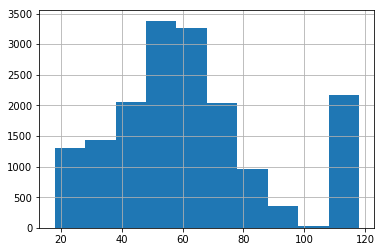

In [204]:
profile.age.hist();

## Data Preparation  (CRISP-DM Step 3)
- are there any missing values?
    - the gender and income columns in the profile seem to be have missing values
    - if a row is missing gender then it is missing income and vice versa
    - we choose to drop these users out of our analysis
    - another thing we observe is that there are users who have not been shown a single offer
- are there any duplicate values?
    - There are users who might receive the same offer twice, and both of them can be marked complete using a common set of transactions.
- are there any categorical variables?
    - the offers in the portfolios have channels and offer_type which we will convert into dummy variables
- are there variables that need cleaning?
    - each transaction type has a different type of value stored as a dict, we wil need to extract the data into separate columns
    - since a user might be shown the same offer more than once, we need to make sure that we use the time columns to identify which offer receivals are related to which offer views and completions

In [2]:
def attach_dict_cols(df, event, col='value'):
    """
    A helper function to clean the transactions data.
    
    Args:
        df: A dataframe that contains all the transactions
        event: the type of event we want to filter and clean. This should be one of the values in the 'event' column in df
        col: The column which contains the dict describing the various attributes of this event
    Returns:
        A dataframe of the specific event with the dict in the value col transformed to separate columns.
    """
    df = df[df['event'] == event].copy()
    attributes = pd.DataFrame(list(df[col]), index=df.index)
    attributes.columns = [col.replace(' ', '_') for col in attributes.columns]
    df = pd.concat([df.drop('value', axis=1), attributes], axis=1, sort=False).reset_index(drop=True)
    return df

transcript['transcript_id'] = np.arange(transcript.shape[0])
received = attach_dict_cols(transcript, 'offer received')
viewed = attach_dict_cols(transcript, 'offer viewed')
completed = attach_dict_cols(transcript, 'offer completed')
transaction = attach_dict_cols(transcript, 'transaction')

#received.groupby('offer_id')['time'].value_counts().unstack()

In [3]:
portfolio['duration_hours'] = portfolio.duration * 24
portfolio['offer_id'] = portfolio.id

received['receive_id'] = transcript['transcript_id']
received['time_receive'] = received['time']
received = pd.merge(received, portfolio[['offer_id', 'duration_hours', 'offer_type', 'difficulty', 'channels']],
                    on='offer_id') 
received['end_time'] = received['time'] + received.duration_hours

viewed = pd.merge_asof(viewed, received[['person', 'time', 'offer_id', 'time_receive', 'receive_id']].sort_values('time'),
                    by=['person', 'offer_id'], on='time')
received = received.drop(['receive_id', 'time'], axis=1)

In [4]:
rc = pd.concat([received, completed], sort=False).sort_values('time')

rec_dict = {person:{offer:deque() for offer in portfolio.id} for person in profile.id}

# loop through all the receives and completes
# each time you see a complete find the first receive of the same offer that is still open 
#rec_dict = person -> offer -> [(transcript_id, end_time)]
complete_list = []
for tup in (received.itertuples(index=False)):
    rec_dict[tup.person][tup.offer_id].append((tup.transcript_id,tup.end_time))

for tup in (completed.itertuples(index=False)):
    stash = rec_dict[tup.person][tup.offer_id]
    found = False
    while stash and (not found):
        rec = stash.popleft()
        if rec[1] >= tup.time:
            complete_list.append(rec[0])
            found = True
    if not found:
        raise

assert completed.shape[0] == len(complete_list)

In [5]:
completed['receive_id'] = complete_list

received = received.merge(viewed[['receive_id', 'time']], left_on='transcript_id', right_on='receive_id', 
                          how='left', suffixes=('', '_view'))

received = received.merge(completed[['receive_id', 'time']], left_on='transcript_id', right_on='receive_id',
                         how='left', suffixes=('_view', '_complete'))

In [6]:
df = received.copy()

df['viewed'] = (~df.time_view.isnull())
df['completed'] = (~df.time_complete.isnull())

channels = set(x for list_ in portfolio.channels.values for x in list_)
for channel in channels:
    df[channel] = df.channels.apply(lambda _: (channel in _))

df['offer_type_dummy'] = df['offer_type']
df = pd.get_dummies(df, columns=['offer_type'])

In [7]:
df.groupby(['offer_type_dummy', 'viewed'])['completed'].value_counts().unstack()

completed                  False    True 
offer_type_dummy viewed                  
bogo             False   10614.0  11748.0
                 True     4216.0   3921.0
discount         False    9740.0  13440.0
                 True     2893.0   4470.0
informational    False   11449.0      NaN
                 True     3786.0      NaN

In [8]:
clean_profile = profile.dropna().copy()
clean_profile['person'] = clean_profile['id']

In [9]:
clean_profile = pd.get_dummies(clean_profile, columns=['gender'], prefix='gender')
profile_cols = ['age', 'became_member_on', 'gender_M', 'gender_O', 'gender_F', 'income', 'person']
#profile_cols = ['age', 'became_member_on', 'gender', 'income', 'person']

df = pd.merge(df, clean_profile[profile_cols], on='person')

In [10]:
df.groupby('viewed')['completed'].value_counts().unstack()

completed,False,True
viewed,,
False,25451,24319
True,8606,8125


In [11]:
df['label'] = (df['viewed'] == df['completed']).astype(int)

In [12]:
all_cols = ['duration_hours', 'difficulty', 'mobile', 'social', 'email', 'web', 
            'offer_type_bogo', 'offer_type_discount', 'offer_type_informational', 
            'age', 'became_member_on', 'gender_M', 'gender_F', 'gender_O', 'income', 'label']

In [13]:
df = df[all_cols].copy().astype(int)

In [14]:
df = df[df.offer_type_informational == 0].copy()

## Modeling  (CRISP-DM Step 4)
- In this section we will try and predict the labels for customers that have been shown an offer
- the label we have assigned is positive when the customer completes and offer if and only if they have been seen the offer
- We will split the data into training and test sets 
- we will then train a AdaBoostClassifier and evaluate its performance on unseen data, the test set

In [164]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score

In [165]:
features = df.drop('label', axis=1)
labels = df['label']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

In [170]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    results = {}
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    
    training_pred = learner.predict(X_train[:1000])
    results['train_acc'] = accuracy_score(y_train[:1000], training_pred)
    results['train_f'] = fbeta_score(y_train[:1000], training_pred, 0.5)
    results['train_prec'] = precision_score(y_train[:1000], training_pred)
    results['train_rec'] = recall_score(y_train[:1000], training_pred)
    
    y_pred = learner.predict(X_test)
    results['test_acc'] = accuracy_score(y_test, y_pred)
    results['test_f'] = fbeta_score(y_test, y_pred, 0.5)
    results['test_prec'] = precision_score(y_test, y_pred)
    results['test_rec'] = recall_score(y_test, y_pred)
    
    return results

In [171]:
clf_1 = DecisionTreeClassifier()
clf_2 = AdaBoostClassifier()
clf_3 = GradientBoostingClassifier()
clf_4 = RandomForestClassifier()

sizes = [int(X_train.shape[0] * 0.02), int(X_train.shape[0]*0.2), X_train.shape[0]]
results = {}
for clf in [clf_2, clf_3, clf_4, clf_1]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i in sizes:
        results[clf_name][i] = train_predict(clf, i, X_train, y_train, X_test, y_test)

In [172]:
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
from plotly.tools import make_subplots

In [173]:
fig = make_subplots(rows=2, cols=4, subplot_titles=('Training Accuracy', 'Training F-Score', 'Training Precision', 'Training Recall',
                                                    'Testing Accuracy', 'Testing F-Score', 'Testing Precision', 'Testing Recall'))
trace_dict = {}
title_dict = {}
for i, metric in enumerate(['acc', 'f', 'prec', 'rec']):
    for j, tt in enumerate(['train', 'test']):
        trace_dict[(j+1, i+1)] = []
        for (clf_name, results_by_size), color in zip(results.items(), ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']):
            trace = go.Bar(name=clf_name, x=['2%', '20%', '100%'], y=[results_by_size[s][f'{tt}_{metric}'] for s in sizes],
                          legendgroup=clf_name, showlegend=(i==0 and j==0), marker={'color':color})
            trace_dict[(j+1, i+1)].append(trace)
        title_dict[(j+1, i+1)] = f'{tt}_{metric}'
for (r, c), traces in trace_dict.items():
    for trace in traces:
        fig.append_trace(trace, row=r, col=c)
    #title = title_dict[(r,c)]
    if r==1 and c==1:
        fig.update({'layout':{'xaxis':{'type':'category'}}})
    else:
        fig.update({'layout':{f'xaxis{(r-1)*4 + c}':{'type':'category'}}})
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]  [ (1,4) x4,y4 ]
[ (2,1) x5,y5 ]  [ (2,2) x6,y6 ]  [ (2,3) x7,y7 ]  [ (2,4) x8,y8 ]



of the four models we have chosen AdaBoost seems to attain the best F-score. GradientBoosting also seems to be a very good candidate with higher precision than AdaBoost on large training sizes. RandomForest and DecisionTree seem to overfit to the data since their training scores on each of the metrics are higher but the test scores are lower compared to the other two models.

### Model Tuning
- Next we go ahead with the AdaBoost Classifier and attempt to tune the parameters by performing a grid search. We pick 2 parameters the learning rate and the number of estimators

In [174]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = AdaBoostClassifier()

parameters = {'learning_rate': [1.0, 0.9, 0.5, 0.25],
               'n_estimators':[25,50,100,200] }

scorer = make_scorer(fbeta_score, beta=0.5)
grid_search = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

In [175]:
grid_fit = grid_search.fit(X_train, y_train)

In [179]:
opt_clf = grid_fit.best_estimator_

opt_pred = opt_clf.predict(X_test)

opt_fscore = fbeta_score(y_test, opt_pred, 0.5) 
opt_accuracy = accuracy_score(y_test, opt_pred)
opt_prec = precision_score(y_test, opt_pred)
opt_rec = recall_score(y_test, opt_pred)

In [180]:
opt_fscore, opt_accuracy, opt_prec, opt_rec

(0.55867985714872126,
 0.62296067964814672,
 0.58739749676305564,
 0.46729613733905578)

In [178]:
grid_fit.best_params_

{'learning_rate': 0.9, 'n_estimators': 25}

- The best parameter combination comes out to be one where we use a maximum of 25 estimators and a learning rate of 0.9
- The F-beta score of the tuned model is almost the same as the untuned model, so in this particular case we do not see any improvement by tuing over these parameter sets

### Feature Importance
- Next we look at the features that were crucial in making the classifier perform as well as it does

In [135]:
X_train.columns

Index(['duration_hours', 'difficulty', 'mobile', 'social', 'email', 'web',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'age', 'became_member_on', 'gender_M', 'gender_F', 'gender_O',
       'income'],
      dtype='object')

In [157]:
feature_scores = list(zip(X_train.columns, opt_clf.feature_importances_))
feature_scores = sorted(feature_scores, key=lambda _:-_[1])
feature_scores_df= pd.DataFrame(feature_scores, columns=['feature', 'score'])
feature_scores_df['cumulative_score'] = feature_scores_df.score.cumsum()
feature_scores_df.head()

,feature,score,cumulative_score
0,income,0.40,0.40
1,became_member_on,0.16,0.56
2,difficulty,0.12,0.68
3,age,0.12,0.80
4,duration_hours,0.08,0.88


In [156]:
trace = go.Scatter(
    x=feature_scores_df.feature,
    y=feature_scores_df.cumulative_score,
    mode='lines+markers'
)
layout = go.Layout({'xaxis':{'tickangle':-45, 'tickfont':{'size':10}}})
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

- From the above plot we see that the top 5 features contribute to 88% of the importance score in the model. 
- Income is the top feature that is being used which should not be surprising as we expect lower income groups to be more responsive customers as they try to find the best bargains. Where as the high income group probably do not care about offers all that much.
- Gender apparently does not play any role in our classifier, but age does seem to be an important factor
- In the next part we try and use only the top 5 features to see if we can improve the performance of the model

### Feature Selection

In [159]:
from sklearn.base import clone

In [163]:
top_features = ['income', 'became_member_on', 'difficulty', 'age', 'duration_hours']
X_train_subset = X_train[top_features].copy()
X_test_subset = X_test[top_features].copy()

clf = (clone(opt_clf)).fit(X_train_subset, y_train)

subset_pred = clf.predict(X_test_subset)
print('F-score after dropping features ', f1_score(y_test, subset_pred))
print('F-score before dropping features ', opt_fscore)

F-score after dropping features  0.503554274736
F-score before dropping features  0.521013186605


- We are not able to achieve almost the same f-score with just the top 5 features, but it does come fairly close.